# Euclid AAS 247 Workshop -- 2c. High Redshift AGN search

## Learning Goals

By the end of this tutorial, you will: 
- Understand how to access data from the photo-z catalog
- Use the photo-z catalog to find the highest redshift AGN
- Make a color-color plot of the high redshift AGN vs galaxies.

## Introduction

Euclid launched in July 2023 as a European Space Agency (ESA) mission with involvement by NASA. The primary science goals of Euclid are to better understand the composition and evolution of the dark Universe. The Euclid mission is providing space-based imaging and spectroscopy as well as supporting ground-based imaging to achieve these primary goals. These data will be archived by multiple global repositories, including IRSA, where they will support transformational work in many areas of astrophysics.

Euclid Quick Release 1 (Q1) consists of consists of ~30 TB of imaging, spectroscopy, and catalogs covering four non-contiguous fields: Euclid Deep Field North (22.9 sq deg), Euclid Deep Field Fornax (12.1 sq deg), Euclid Deep Field South (28.1 sq deg), and LDN1641.

This exercise notebook gives you the opportunity to use the photo-z catalog to find the highest redshift Active Galactic Nuclei (AGN) (z=4 to 6) and make a color-color diagram ((Y−J) vs (VIS−Y)) to determine the spectral slope and dust reddening. Plot galaxies at the same redshifts on the same color-color plot to see where they fall compared to the AGN.

## Imports

In [ ]:
# Uncomment the next line to install dependencies if needed.
# !pip install numpy 'astropy>=5.3' matplotlib 'astroquery>=0.4.10' 'sep>=1.4' fsspec

In [151]:
import re

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch,  ZScaleInterval, SquaredStretch
from astropy.wcs import WCS
from astropy import units as u

from astroquery.ipac.irsa import Irsa
import sep

import pandas as pd

In [152]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [153]:
# ## Set a longer timeout (default is 60 seconds)
Irsa.TIMEOUT = 300  # 5 minutes

# Euclid Q1 High redshift AGN query

## 1. Search for Euclid PHZ photo-z catalog to find highest redshift AGN

Helpful notebooks -- 1b_Catalog_Access

Use the Euclid Photo-z catalog ('Euclid Q1 PHZ Photo-z Catalog') to find the highest redshift ('phz_median') AGN ('phz_classification' = 4). The AGN range should be between phz_median= 4 and 6. 

Do a separate query for galaxies ('phz_classification' = 2) in the same redshift bin.

Read in all the available Euclid fluxes ('flux_vis_unif', 'flux_y_unif', 'flux_j_unif', 'flux_h_unif')

In [154]:
Irsa.list_catalogs(filter='euclid')

{'euclid_q1_mer_catalogue': 'Euclid Q1 MER Catalog',
 'euclid_q1_mer_morphology': 'Euclid Q1 MER Morphology',
 'euclid_q1_mer_cutouts': 'Euclid Q1 MER Cutouts',
 'euclid_q1_phz_photo_z': 'Euclid Q1 PHZ Photo-z Catalog',
 'euclid_q1_phz_star_sed': 'Euclid Q1 PHZ Star SED Catalog',
 'euclid_q1_phz_galaxy_sed': 'Euclid Q1 PHZ Galaxy SED Catalog',
 'euclid_q1_phz_classification': 'Euclid Q1 PHZ Classification Catalog',
 'euclid_q1_phz_qso_physical_parameters': 'Euclid Q1 PHZ QSO Physical Parameters Catalog',
 'euclid_q1_phz_nir_physical_parameters': 'Euclid Q1 PHZ NIR Physical Parameters Catalog',
 'euclid_q1_phz_star_template': 'Euclid Q1 PHZ Star Template Catalog',
 'euclid_q1_spectro_zcatalog_spe_quality': 'Euclid Q1 SPE Redshift Catalog - Quality',
 'euclid_q1_spectro_zcatalog_spe_classification': 'Euclid Q1 SPE Redshift Catalog - Classification',
 'euclid_q1_spectro_zcatalog_spe_galaxy_candidates': 'Euclid Q1 SPE Redshift Catalog - Galaxy Candidates',
 'euclid_q1_spectro_zcatalog_spe_

In [155]:
table_phz= 'euclid_q1_phz_photo_z'


In [156]:
columns_info = Irsa.list_columns(catalog=table_phz)
print(len(columns_info))

67


In [157]:
columns_info

{'object_id': 'Unique ID of the object in the survey, as set by MER',
 'phz_median': 'The median of the PHZ PDF',
 'phz_mode_1': 'The first mode of the PHZ PDF',
 'phz_mode_1_area': 'The total area of the first mode',
 'phz_mode_2': 'The second mode of the PHZ PDF',
 'phz_mode_2_area': 'The total area of the second mode',
 'bias_id': 'The identifier to be used for retrieving the bias correction shift from the bias correction map',
 'tom_bin_id': 'The identifier of the tomographic bin the source belongs to (Equipopulated-bins)',
 'alt_tom_bin_id': 'The identifier of the alternate tomographic bin the source belongs to (Equidistant-bins)',
 'pos_tom_bin_id': 'The identifier of the photometric clustering tomographic bin the source belongs to (Equipopulated-bins)',
 'flag_som_tomobin': 'Flag telling if the source belong to a combination of SOM cell and Tom. bin which can be calibrated (=1) or not (=0).',
 'flag_som_alt_tomobin': 'Flag telling if the source belong to a combination of SOM cel

In [158]:
## Do two separate queries to get top 500 AGN and top 500 galaxies
# ORDER BY phz.phz_median DESC  \

adql_phz4 = f"SELECT TOP 500 phz.object_id, phz.phz_median, phz.phz_classification, phz.flux_vis_unif,  phz.flux_y_unif, \
phz.flux_j_unif, phz.flux_h_unif \
FROM {table_phz} AS phz \
WHERE  phz.phz_median BETWEEN 4 AND 6 \
AND phz.phz_classification=4 \
"

## Run the query
result_phz4 = Irsa.query_tap(adql_phz4).to_table()

In [159]:
df_result_phz4=result_phz4.to_pandas()

In [160]:
df_result_phz4

,object_id,phz_median,phz_classification,flux_vis_unif,flux_y_unif,flux_j_unif,flux_h_unif
0,2699092539669517663,4.22,4,3.045710,3.490423,0.850523,2.443298
1,2690478319669456754,4.46,4,0.837311,1.046420,1.333931,1.215627
2,2694458147667707607,4.28,4,1.150006,1.009209,0.881425,0.858653
3,2694284179667856710,4.05,4,0.831080,1.488437,0.891460,0.985339
4,2694467879667708282,4.11,4,0.849238,1.075433,0.836391,0.661689
...,...,...,...,...,...,...,...
495,2653668732673684995,4.09,4,0.990461,0.121961,0.305885,0.315019
496,2651013693676719215,4.02,4,2.050161,2.044489,2.228499,1.524223
497,2644901285674892644,4.12,4,0.818231,1.151690,0.840099,0.943918
498,2655043837676053233,4.58,4,0.115944,0.546562,1.356197,0.744620


In [161]:
## galaxies now

adql_phz2 = f"SELECT TOP 500 phz.object_id, phz.phz_median, phz.phz_classification, phz.flux_vis_unif,  phz.flux_y_unif, \
phz.flux_j_unif, phz.flux_h_unif \
FROM {table_phz} AS phz \
WHERE  phz.phz_median BETWEEN 4 and 6 \
AND phz.phz_classification=2 \
AND MOD(phz.object_id, 10) = 0 \
"

## Run the query
result_phz2 = Irsa.query_tap(adql_phz2).to_table()

In [162]:
df_result_phz2=result_phz2.to_pandas()

In [163]:
df_result_phz2

,object_id,phz_median,phz_classification,flux_vis_unif,flux_y_unif,flux_j_unif,flux_h_unif
0,2742169226655551350,4.52,2,0.073983,0.292235,0.355270,0.381795
1,2741029793655771550,4.32,2,0.211748,0.343047,0.439469,0.468293
2,2744598412655776610,4.32,2,0.072393,-0.025727,0.128399,0.182334
3,2741747283655857420,4.25,2,0.179106,0.146868,0.391546,0.512368
4,2742773594655904820,4.42,2,0.151207,0.228322,0.463697,0.380775
...,...,...,...,...,...,...,...
495,2638279967657705890,5.90,2,0.086357,-0.026203,1.542396,0.113711
496,2635515020657750920,4.89,2,0.199056,0.617498,0.737818,0.280570
497,2638159113658341040,5.94,2,0.237566,0.806032,1.370826,1.428875
498,2642253836658344100,5.23,2,0.249155,1.030372,0.663781,0.978449


## 2. Make a color-color diagram of the highest redshift AGN vs galaxies

Helpful notebooks -- 1b_Catalog_Access

Use the output of your photo-z catalog query to create a color-color diagram and search for --

In [164]:
## Make a function to convert from the flues to magnitudes

def flux_to_mag(flux):
    flux = np.where(flux > 0, flux, np.nan)
    return -2.5 * np.log10(flux) + 23.9  

In [165]:
## Add extra columns in the dataframe for the magnitudes

df_result_phz4['mag_vis'] = flux_to_mag(df_result_phz4['flux_vis_unif'])
df_result_phz4['mag_y']   = flux_to_mag(df_result_phz4['flux_y_unif'])
df_result_phz4['mag_j']   = flux_to_mag(df_result_phz4['flux_j_unif'])
df_result_phz4['mag_h']   = flux_to_mag(df_result_phz4['flux_h_unif'])

df_result_phz2['mag_vis'] = flux_to_mag(df_result_phz2['flux_vis_unif'])
df_result_phz2['mag_y']   = flux_to_mag(df_result_phz2['flux_y_unif'])
df_result_phz2['mag_j']   = flux_to_mag(df_result_phz2['flux_j_unif'])
df_result_phz2['mag_h']   = flux_to_mag(df_result_phz2['flux_h_unif'])

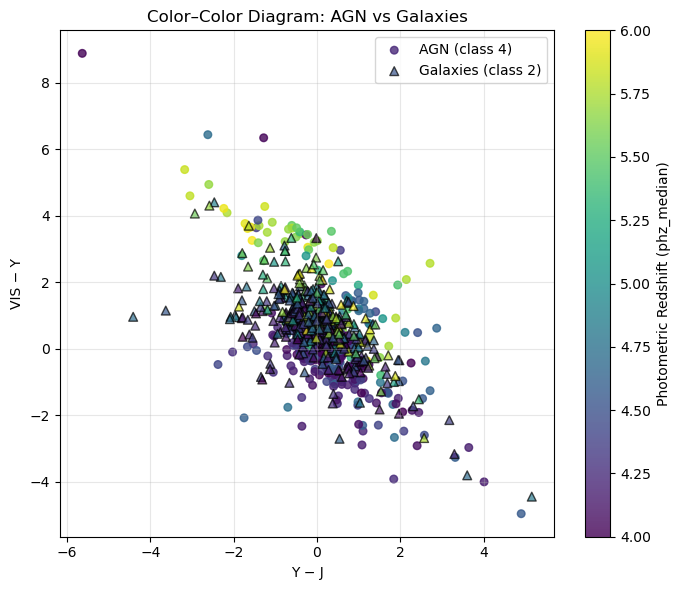

In [166]:
# ## Make a color-color diagram 


plt.figure(figsize=(7,6))

# --- AGN (phz_classification = 4) ---
sc4 = plt.scatter(
    df_result_phz4['mag_y'] - df_result_phz4['mag_j'],
    df_result_phz4['mag_vis'] - df_result_phz4['mag_y'],
    c=df_result_phz4['phz_median'],
    cmap='viridis',
    s=30,
    alpha=0.8,
    marker='o',              # circles
    label='AGN (class 4)'
)

# --- Galaxies (phz_classification = 2) ---
sc2 = plt.scatter(
    df_result_phz2['mag_y'] - df_result_phz2['mag_j'],
    df_result_phz2['mag_vis'] - df_result_phz2['mag_y'],
    c=df_result_phz2['phz_median'],
    cmap='viridis',
    s=40,
    alpha=0.7,
    marker='^',              # triangles
    edgecolors='black',      # optional outline
    label='Galaxies (class 2)'
)

# Colorbar applies to both
cbar = plt.colorbar(sc4)
cbar.set_label('Photometric Redshift (phz_median)')

plt.xlabel('Y − J')
plt.ylabel('VIS − Y')
plt.title('Color–Color Diagram: AGN vs Galaxies')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

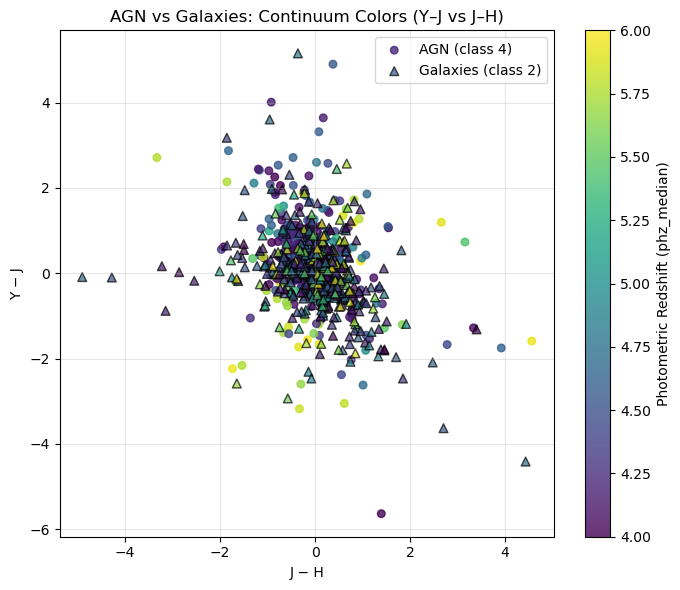

In [167]:

plt.figure(figsize=(7,6))

# --- AGN (phz_classification = 4) ---
sc4 = plt.scatter(
    df_result_phz4['mag_j'] - df_result_phz4['mag_h'],
    df_result_phz4['mag_y'] - df_result_phz4['mag_j'],
    c=df_result_phz4['phz_median'],
    cmap='viridis',
    s=30,
    alpha=0.8,
    marker='o',            # circles
    label='AGN (class 4)'
)

# --- Galaxies (phz_classification = 2) ---
sc2 = plt.scatter(
    df_result_phz2['mag_j'] - df_result_phz2['mag_h'],
    df_result_phz2['mag_y'] - df_result_phz2['mag_j'],
    c=df_result_phz2['phz_median'],
    cmap='viridis',
    s=40,
    alpha=0.7,
    marker='^',            # triangles
    edgecolors='black',    # helps visibility
    label='Galaxies (class 2)'
)

# Colorbar (same for both classes)
cbar = plt.colorbar(sc4)
cbar.set_label('Photometric Redshift (phz_median)')

plt.xlabel('J − H')
plt.ylabel('Y − J')
plt.title('AGN vs Galaxies: Continuum Colors (Y–J vs J–H)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

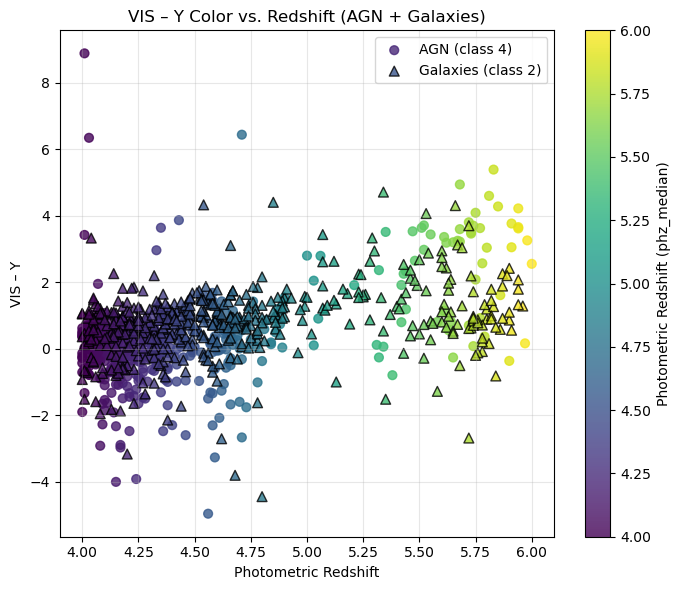

In [168]:


plt.figure(figsize=(7,6))

# --- AGN (phz_classification = 4) ---
sc4 = plt.scatter(
    df_result_phz4['phz_median'],
    df_result_phz4['mag_vis'] - df_result_phz4['mag_y'],
    c=df_result_phz4['phz_median'],
    cmap='viridis',
    s=40,
    alpha=0.8,
    marker='o',               # circles
    label='AGN (class 4)'
)

# --- Galaxies (phz_classification = 2) ---
sc2 = plt.scatter(
    df_result_phz2['phz_median'],
    df_result_phz2['mag_vis'] - df_result_phz2['mag_y'],
    c=df_result_phz2['phz_median'],
    cmap='viridis',
    s=50,
    alpha=0.8,
    marker='^',               # triangles
    edgecolors='black',       # improves visibility
    label='Galaxies (class 2)'
)

# Shared colorbar
cbar = plt.colorbar(sc4)
cbar.set_label('Photometric Redshift (phz_median)')

plt.xlabel('Photometric Redshift')
plt.ylabel('VIS – Y')
plt.title('VIS – Y Color vs. Redshift (AGN + Galaxies)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## About this Notebook

**Author(s)**: Tiffany Meshkat <br>
**Keyword(s)**: Euclid, Q1, AAS 247 Workshop <br>
**First published**: Dec 11, 2025 <br>
**Last updated**: Dec 11, 2025